In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

Pipeline:

0) data prep
1) design model (input, output size, forward pass)
2) construct loss + optimizer
3) training loop:
       - forward pass: compute prediction and loss
       - backward pass: gradients
      - update weights

Data prep:

In [2]:
data = pd.read_csv('data.csv')
target = data['y']


In [3]:
data.head()

,Unnamed: 0,X53416,M83670,X90908,M97496,X90908.1,U37019,R48602,T96548,X64559,...,H87456,R64130,H11125.1,U22055,L22524,M13699.1,X54489,T55008,M10065.2,y
0,0,70,-81,25,10,22,113,36,163,9,...,75,5,68,138,53,-4,123,2,19,tumor
1,1,108,-30,-7,60,0,24,8,113,-3,...,186,6,60,93,140,-3,271,-1,-51,tumor
2,2,75,-1,5,48,6,34,27,35,-1,...,186,225,94,62,39,-14,127,7,192,tumor
3,3,871,4,14,78,-6,85,65,227,19,...,77,6,78,30,87,-4,59,3,367,tumor
4,4,-92,-34,14,19,11,-6,27,-8,9,...,87,303,204,81,105,9,265,-2,126,tumor


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Columns: 7466 entries, Unnamed: 0 to y
dtypes: int64(7465), object(1)
memory usage: 2.1+ MB


In [5]:
print(data.isna().sum())

Unnamed: 0    0
X53416        0
M83670        0
X90908        0
M97496        0
             ..
M13699.1      0
X54489        0
T55008        0
M10065.2      0
y             0
Length: 7466, dtype: int64


In [6]:
data.dtypes

Unnamed: 0     int64
X53416         int64
M83670         int64
X90908         int64
M97496         int64
               ...  
M13699.1       int64
X54489         int64
T55008         int64
M10065.2       int64
y             object
Length: 7466, dtype: object

In [7]:
le = LabelEncoder()
nptarget = target.copy()
nptarget = le.fit_transform(nptarget)
print(nptarget)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [8]:
data.head()

,Unnamed: 0,X53416,M83670,X90908,M97496,X90908.1,U37019,R48602,T96548,X64559,...,H87456,R64130,H11125.1,U22055,L22524,M13699.1,X54489,T55008,M10065.2,y
0,0,70,-81,25,10,22,113,36,163,9,...,75,5,68,138,53,-4,123,2,19,tumor
1,1,108,-30,-7,60,0,24,8,113,-3,...,186,6,60,93,140,-3,271,-1,-51,tumor
2,2,75,-1,5,48,6,34,27,35,-1,...,186,225,94,62,39,-14,127,7,192,tumor
3,3,871,4,14,78,-6,85,65,227,19,...,77,6,78,30,87,-4,59,3,367,tumor
4,4,-92,-34,14,19,11,-6,27,-8,9,...,87,303,204,81,105,9,265,-2,126,tumor


In [9]:
data = data.drop(columns=['y'])

Data vis

In [15]:
dataCop = data.copy()
pca = PCA(n_components = 2)
pC = pca.fit_transform(dataCop)
initial = pd.DataFrame(pC, columns = ['P1','P2']) #P1 and P2 stand for the first and second components found from PCA
initial.head()

,P1,P2
0,2040.945947,-4084.957492
1,-990.060292,-2437.466647
2,-1350.050264,-3809.167600
3,-408.499576,-2760.850117
4,-1660.630452,-3415.964990


In [17]:
targetCol = pd.DataFrame(nptarget,columns=['target'])
targetCol['target'] = targetCol['target'].replace([1],'tumor')
targetCol['target'] = targetCol['target'].replace([0],'normal')
pca_df = pd.concat([initial,targetCol],axis=1)

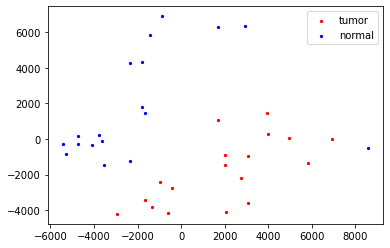

In [18]:
targets = ['tumor','normal']
colors = ['r','b']
for target, color in zip(targets,colors):
    indicesToKeep = targetCol['target'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'P1']
               , pca_df.loc[indicesToKeep, 'P2'], c = color, s = 5)

plt.legend(targets,prop={'size': 10})

In [10]:
datanp = data.to_numpy()
print(datanp)

[[   0   70  -81 ...  123    2   19]
 [   1  108  -30 ...  271   -1  -51]
 [   2   75   -1 ...  127    7  192]
 ...
 [  33 1282  116 ...    7    3  -69]
 [  34   68  718 ...   21   22 -214]
 [  35  928  332 ...   32   -5   72]]


In [11]:
X,y = datanp,nptarget

n_samples,n_features = X.shape
print(n_samples,n_features)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=1234)

#feature scaling
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))



y_train = y_train.view(y_train.shape[0],1)
y_test = y_test.view(y_test.shape[0],1)

36 7465


Model

In [19]:
class LogisticRegression(nn.Module):
    def __init__(self,n_input_features):
        super(LogisticRegression,self).__init__()
        self.linear= nn.Linear(n_input_features,1)

    def forward(self,x):
        y_predicted = torch.sigmoid(self.linear(x))
        return y_predicted
        
model = LogisticRegression(n_features)

In [20]:
learning_rate = 0.01
criterion = nn.BCELoss() #binary cross entropy loss
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)

Training

In [21]:
num_epochs = 100

for epoch in range(num_epochs):
    #forward pass + loss
    y_pred = model(X_train)
    loss = criterion(y_pred,y_train)
    #backprop
    loss.backward()
    #update weights
    optimizer.step()

    #zero gradients
    optimizer.zero_grad()

    #print info
    if (epoch+1) % 20 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

epoch: 20, loss = 0.0080
epoch: 40, loss = 0.0043
epoch: 60, loss = 0.0029
epoch: 80, loss = 0.0022
epoch: 100, loss = 0.0018


In [23]:
#evaluate model

with torch.no_grad(): #without computational graph
    y_predicted = model(X_test)
    y_predicted_cls = y_predicted.round()
    acc = y_predicted_cls.eq(y_test).sum()/ float(y_test.size(dim=0))
    print(f'accuracy = {acc:.20f}')

accuracy = 1.00000000000000000000


Accuracy is 100%